/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
[GRAPHCUT] step1 elapsed: 1.1983919143676758
[GRAPHCUT] step2 elapsed: 0.015490293502807617
[GRAPHCUT] step3 elapsed: 0.009865283966064453
[GRAPHCUT] step4 elapsed: 9.348208904266357
elapsed 10.57400393486023


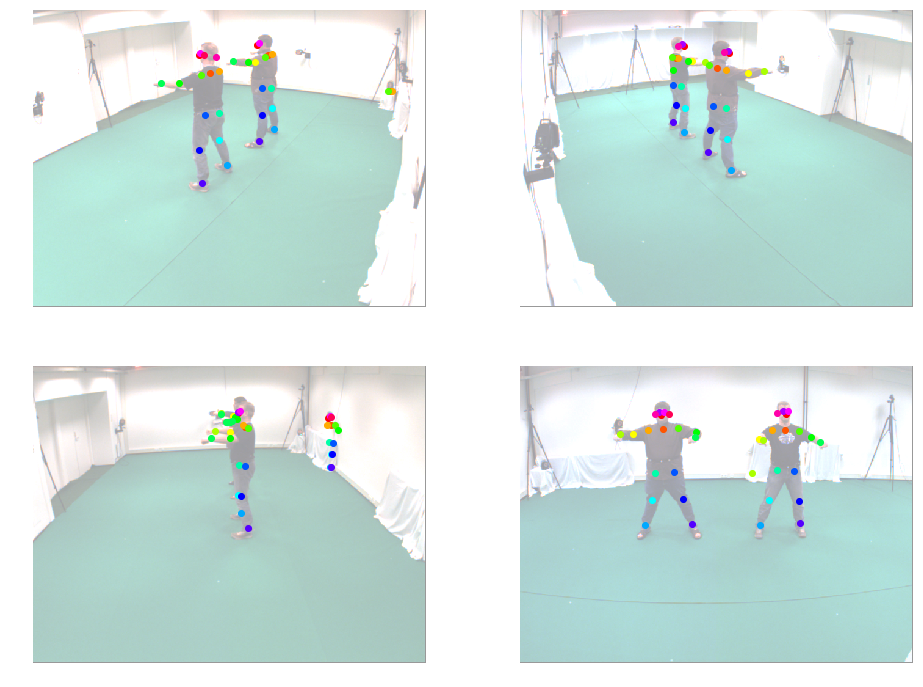

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.insert(0,'../../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../../')
import mvpose.data.transform as tfm
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.pose_estimation.heatmaps as mvhm
from mvpose.candidates import peaks as mvpeaks
import mvpose.pose_estimation.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH, DEFAULT_MAP_IDX
from mvpose.algorithm import graphcut
from cselect import color as cs

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()


from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)
Human_Pose_Gt = Y

# interesting frames: [340, 215, 250]
FRAME = 0

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
with_gpu = False

if with_gpu:
    _start = time()
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
    _end = time(); print('elapsed:', _end - _start)
else:
    hm_file = '/tmp/heatmaps' + str(FRAME) + '.npy'
    paf_file = '/tmp/pafs' + str(FRAME) + '.npy'
    
    if isfile(hm_file) and isfile(paf_file):
        heatmaps = np.load(hm_file)
        pafs = np.load(paf_file)
    else:
        heatmaps = []; pafs = []
        for im in Im:
            _start = time()
            hm, paf = pe.predict_pafs_and_heatmaps(im)
            heatmaps.append(np.squeeze(hm))
            pafs.append(np.squeeze(paf))
            _end = time()
            print('elapsed:', _end - _start)
        heatmaps = np.array(heatmaps)
        pafs = np.array(pafs)
        np.save(hm_file, heatmaps)
        np.save(paf_file, pafs)
        
import mvpose.plot.limbs as pltlimbs

colors = cs.lincolor(19)/255

r = 200
_start = time()
Gr = graphcut.GraphCutSolver(heatmaps, pafs, Calib, r, debug=True)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2,2,idx+1)
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d[idx].n_joints):
        for x,y,score in Gr.peaks2d[idx][jid]:
            ax.scatter(x,y, color=colors[jid])
    
plt.show()

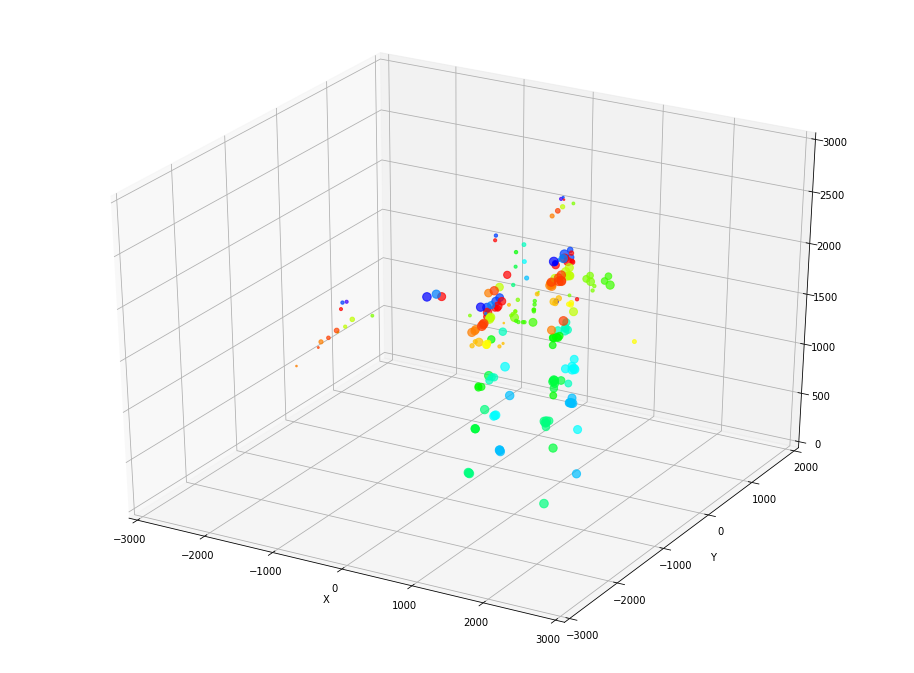

In [2]:
COLORS = cs.lincolor(25)/255
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-3000, 3000])
ax.set_ylim([-3000, 2000])
ax.set_zlim([0, 3000])
ax.set_xlabel('X')
ax.set_ylabel('Y')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Points3d = Gr.peaks3d_weighted

for jid, pts3d in enumerate(Points3d):
    X = pts3d[:,0]
    Y = pts3d[:,1]
    Z = pts3d[:,2]
    W1 = pts3d[:,3]
    W2 = pts3d[:,4]
    
    ax.scatter(X,Y,Z,alpha=0.7, color=COLORS[jid], s=W1*W2*100)
        

plt.show()

In [30]:
from ortools.linear_solver import pywraplp as mip
from mvpose.geometry import geometry as gm
from mvpose.candidates.transitivity import TransitivityLookup
import networkx as nx

points3d = Gr.peaks3d_weighted
limbs3d = Gr.limbs3d

limbSeq = DEFAULT_LIMB_SEQ
sensible_limb_length = DEFAULT_SENSIBLE_LIMB_LENGTH

assert len(limbs3d) == len(limbSeq)
assert len(limbs3d) == len(sensible_limb_length)
n_joints = len(points3d)

_start = time()
# ===========================================
# PARAMETERS
# ===========================================
max_radius = 300
radius = 50
iota_scale = 1

# ===========================================
# COST  FUNCTIONS
# ===========================================
pboost_big = lambda x: np.log((x+1) / (2 * (0.5 * (-x -1)+1))) * 2
pboost_small = lambda x: np.log(x/(1-x))
func1 = lambda u: np.tanh(pboost_small(u))
func2 = lambda d: (-np.tanh((d-radius)/radius) * iota_scale)
func3 = lambda x: pboost_big(x)

# ===========================================
# CREATE COST AND BOOLEAN VARIABLES
# ===========================================
solver = mip.Solver('m', mip.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

D = []  # all nodes of the graph    (jid, a)
E_j = []  # all edges on the joints (jid, a, b)
E_l = []  # all edges on the limbs  (jid1, jid2, a, b)

Nu = {}
Iota = {}
Lambda = {}
Get_Iota = lambda jid, a, b: Iota[jid, min(a, b), max(a, b)]
Get_Lambda = lambda jid1, jid2, a, b: Lambda[jid1, jid2, a, b] \
    if (jid1, jid2, a, b) in Lambda else Lambda[jid2, jid1, b, a]

DEBUG_Nu = []
DEBUG_Iota = []
DEBUG_Lambda = []

Sum = []

for jid, pts3d in enumerate(points3d):
    # ===========================================
    # HANDLE NU
    # ===========================================
    left = pts3d[:,3]
    right = pts3d[:,4]
    unary = np.multiply(left, right)
    n = len(unary)
    for idx in range(n):
        Nu[jid, idx] = solver.BoolVar('nu[%i,%i]' % (jid, idx))
        D.append((jid, idx))
    
    s = solver.Sum(
        Nu[jid, idx] * func1(unary[idx]) for idx in range(n)
    )
    Sum.append(s)
    
    # *********************************************************
    for idx in range(n):
        DEBUG_Nu.append((jid, idx, func1(unary[idx])))
    # *********************************************************
    
    # ===========================================
    # HANDLE IOTA
    # ===========================================
    # (a, b, distance)
    distance = gm.calculate_distance_all4all(
        points3d[jid], points3d[jid], max_distance=max_radius,
        AB_are_the_same=True)
    As = distance[:,0].astype('int32')
    Bs = distance[:,1].astype('int32')
    
    for a, b in zip(As, Bs):
        Iota[jid, a, b] = solver.BoolVar('j[%i,%i,%i]' % (jid, a, b))
        E_j.append((jid, a, b))
    
    s = solver.Sum(
        Iota[jid, int(a), int(b)] * func2(d) for a,b,d in distance
    )
    Sum.append(s)
    
    # *********************************************************
    for a,b,d in distance:
        DEBUG_Iota.append((jid, int(a), int(b), func2(d)))
    # *********************************************************

# ===========================================
# HANDLE LAMBDA
# ===========================================
for lid, ((jid1,jid2), (mindist, maxdist)) in \
        enumerate(zip(limbSeq, sensible_limb_length)):
    assert jid1 != jid2
    ABdistance = gm.calculate_distance_all4all(
        points3d[jid1], points3d[jid2], max_distance=maxdist,
        min_distance=mindist,
        AB_are_the_same=False)
    As = ABdistance[:,0].astype('int32')
    Bs = ABdistance[:,1].astype('int32')
    distance = ABdistance[:,2]
    
    for a,b in zip(As, Bs):
        Lambda[jid1, jid2, a, b] = solver.BoolVar(
            'l[%i,%i,%i,%i]' % (jid1, jid2, a, b))
        E_l.append((jid1, jid2, a, b))
    
    W = limbs3d[lid]
    Scores = W[As,Bs]
  
    s = solver.Sum(
        Get_Lambda(jid1, jid2, a, b) * func3(s) for a,b,s in\
        zip(As, Bs, Scores))
    Sum.append(s)
    
    for a,b,s in zip(As, Bs, Scores):
        DEBUG_Lambda.append((jid1, jid2, a, b, pboost_big(s)))

# ===========================================
# ONLY CONSIDER VALID EDGES
# ===========================================
for jid1, jid2, a, b in E_l:
    solver.Add(
        Lambda[jid1, jid2, a, b] * 2 <= Nu[jid1, a] + Nu[jid2, b])

for jid, a, b in E_j:
    solver.Add(
        Iota[jid, a, b] * 2 <= Nu[jid, a] + Nu[jid, b])

# ===========================================
# HANDLE TRANSITIVITY CONSTRAINTS (1)
# ===========================================

Intra = []  #  [ (jid, a, b, c), ...]
Inter = []  # [ (jid1, a, b, jid2, c), ...]
Intra_choice = []  # [ (jid, a, b, c), ...]
Inter_choice = []  # [ (jid1, a, jid2, b, jid3, c), ...]

transitivity_lookup = TransitivityLookup(D, E_l, E_j)
for q in D:
    intra, intra_choice, inter, inter_choice =\
        transitivity_lookup.query_with_choice(*q)
    Intra += intra
    Inter += inter
    Intra_choice += intra_choice
    Inter_choice += inter_choice

assert len(Inter) == len(set(Inter))
assert len(Intra) == len(set(Intra))
assert len(Inter_choice) == len(set(Inter_choice))
assert len(Intra_choice) == len(set(Intra_choice))

print('-------------------------------------------')
print('Handle transitivity:')
print('\tIntra:\t\t', len(Intra))
print('\tIntra(choice):\t', len(Intra_choice))
print('\tInter:\t\t', len(Inter))
print('\tInter(choice):\t', len(Inter_choice))

# ===========================================
# HANDLE TRANSITIVITY CONSTRAINTS (2)
# ===========================================
for jid, a, b, c in Intra:
    assert a < b < c
    solver.Add(Get_Iota(jid, a, b) + Get_Iota(jid, a, c) - 1 <= \
        Get_Iota(jid, b, c))
    solver.Add(Get_Iota(jid, a, b) + Get_Iota(jid, b, c) - 1 <= \
        Get_Iota(jid, a, c))
    solver.Add(Get_Iota(jid, a, c) + Get_Iota(jid, b, c) - 1 <= \
        Get_Iota(jid, a, b))

for jid1, a, b, jid2, c in Inter:
    solver.Add(
        Get_Lambda(jid1, jid2, a, c) + Get_Lambda(jid1, jid2, b, c) -1 <= \
        Get_Iota(jid1, a, b))
    solver.Add(
        Get_Iota(jid1, a, b) + Get_Lambda(jid1, jid2, a, c) -1 <= \
        Get_Lambda(jid1, jid2, b, c))
    solver.Add(
        Get_Iota(jid1, a, b) + Get_Lambda(jid1, jid2, b, c) -1 <= \
        Get_Lambda(jid1, jid2, a, c))


# ===========================================
# HANDLE CHOICE CONSTRAINTS
# ===========================================
for jid, a, b, c in Intra_choice:  # either take { ab OR ac }
    solver.Add(
        Get_Iota(jid, a, b) + Get_Iota(jid, a, c) <= 1
    )

for jid1, a, jid2, b, jid3, c in Inter_choice:  # { ab OR ac }
    if jid1 == jid2:
        assert jid3 != jid1
        # if  [a]---[b]
        #     |
        #    (c)
        solver.Add(
            Get_Iota(jid1, a, b) + Get_Lambda(jid1, jid3, a, c) <= 1
        )
    elif jid2 == jid3:
        # if  [a]
        #     |   \
        #    (b)   (c)
        solver.Add(
            Get_Lambda(jid1, jid2, a, b) + Get_Lambda(jid1, jid3, a, c) <= 1
        )
    elif jid1 == jid3:
        # if  [a]---[c]
        #     |
        #    (b)
        solver.Add(
            Get_Lambda(jid1, jid2, a, b) + Get_Iota(jid1, a, c) <= 1
        )
    else:
        raise ValueError("nope")
    

# ===========================================
# SOLVE THE GRAPH
# ===========================================
solver.Maximize(solver.Sum(Sum))
RESULT = solver.Solve()
print('-------------------------------------------')
print("\tTime = ", solver.WallTime(), " ms")
print("\tresult:", RESULT)
print('\n\tTotal cost:', solver.Objective().Value())

# ===========================================
# EXTRACT INDIVIDUALS
# ===========================================

valid_3d_points = set()
count_invalid_points = 0
for (jid, idx), v in Nu.items():
    if v.solution_value() > 0:
        valid_3d_points.add((jid, idx))
    else:
        count_invalid_points += 1
print("\n# valid points:\t\t", len(valid_3d_points))
print("# invalid points:\t", count_invalid_points)

G = nx.Graph()
for (jid1, jid2, a, b), v in Lambda.items():
    if v.solution_value() > 0:
        assert (jid1, a) in valid_3d_points and (jid2, b) in valid_3d_points
        candA = transitivity_lookup.lookup[jid1, a]
        candB = transitivity_lookup.lookup[jid2, b]
        G.add_edge(candA, candB)

for (jid, a, b), v in Iota.items():
    if v.solution_value() > 0:
        assert (jid, a) in valid_3d_points and (jid, b) in valid_3d_points
        candA = transitivity_lookup.lookup[jid, a]
        candB = transitivity_lookup.lookup[jid, b]
        G.add_edge(candA, candB)

persons = []
for comp in nx.connected_components(G):
    person = [None] * n_joints
    for node in comp:
        jid, idx = transitivity_lookup.reverse_lookup[node]
        if person[jid] is None:
            person[jid] = []
        person[jid].append(points3d[jid][idx])
    persons.append(person)

for pid in range(len(persons)):
    for jid in range(n_joints):
        if persons[pid][jid] is not None:
            persons[pid][jid] = np.array(persons[pid][jid])

# ===========================================
# DEBUG: PRINT SOME STATISTICS
# ===========================================
_end = time()
assert len(Nu) == len(D)
assert len(E_j) == len(Iota)
assert len(E_l) == len(Lambda)
DEBUG_Nu = np.array(DEBUG_Nu)
DEBUG_Iota = np.array(DEBUG_Iota)
DEBUG_Lambda = np.array(DEBUG_Lambda)
print('\n-------------------------------------------')
print("\tNu:\t", len(Nu))
print("\tIota:\t", len(Iota))
print("\tLambda:\t", len(Lambda))
print('-------------------------------------------\n')
print('total elapsed:', _end - _start)
print('')
print('#persons:', len(persons))


-------------------------------------------
Handle transitivity:
	Intra:		 315
	Intra(choice):	 38
	Inter:		 2565
	Inter(choice):	 732
-------------------------------------------
	Time =  3877  ms
	result: 0

	Total cost: 1069.5215078676329

# valid points:		 157
# invalid points:	 51

-------------------------------------------
	Nu:	 208
	Iota:	 284
	Lambda:	 733
-------------------------------------------

total elapsed: 3.891798496246338

#persons: 8


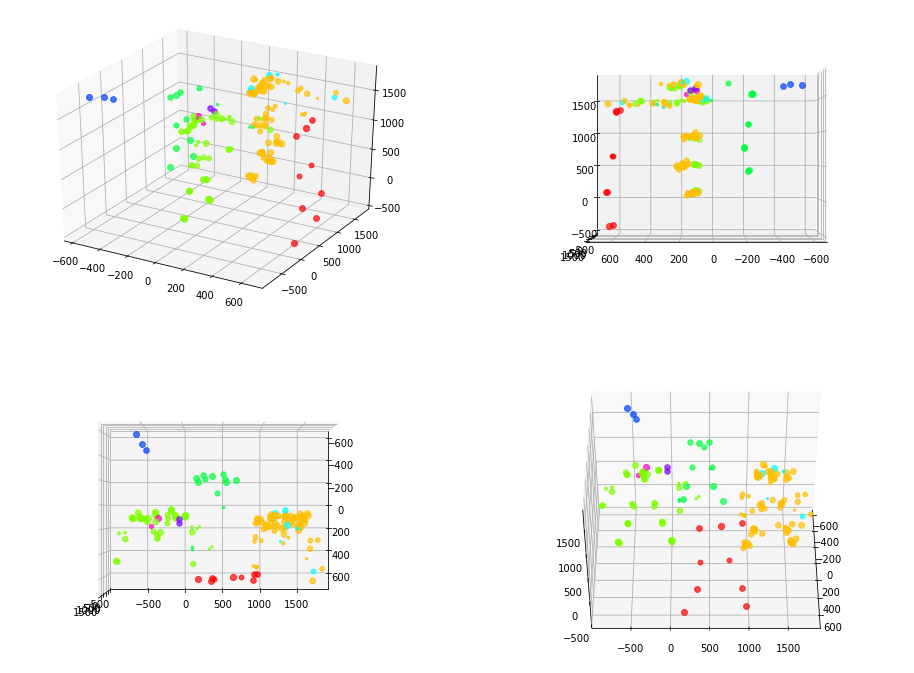

In [31]:
COLORS = cs.lincolor(max(1, len(persons) + 1))/255
fig = plt.figure(figsize=(16,12))
ax.set_xlim([-3000, 3000])
ax.set_ylim([-3000, 2000])
ax.set_zlim([0, 3000])
ax.set_xlabel('X')
ax.set_ylabel('Y')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def plot(ax):
    for pid, person in enumerate(persons):
        for jid, pts3d in enumerate(person):
            if pts3d is not None:
                X = pts3d[:,0]
                Y = pts3d[:,1]
                Z = pts3d[:,2]
                W1 = pts3d[:,3]
                W2 = pts3d[:,4]

                ax.scatter(X,Y,Z,alpha=0.7, color=COLORS[pid], s=W1*W2*50)

ax = fig.add_subplot(221, projection='3d'); plot(ax)
ax = fig.add_subplot(222, projection='3d'); ax.view_init(0, 90); plot(ax)
ax = fig.add_subplot(223, projection='3d'); ax.view_init(90, 0); plot(ax)
ax = fig.add_subplot(224, projection='3d'); ax.view_init(45, 0); plot(ax)


                
plt.show()